In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
from scipy.io import loadmat
import os
from os import listdir
import pandas as pd
from skimage import io
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pickle

from utils import *

In [4]:
#selected subset of dates. 
val_dates = ['180327','180329']
test_dates = ['180330','180331']
bad_dates = ['180326', '180328', '171019', '180715', '180716', '180717']

CH = 23
train_loader, val_loader, test_loader = create_dataloaders(val_dates=val_dates, test_dates=test_dates, batch_size=128, version='_Goose_1st_1', CH=CH, upsample=True)

NameError: name 'load_path' is not defined

In [ ]:
len(train_loader), len(val_loader), len(test_loader)

In [4]:
class MLP(nn.Module): # add dropo
    def __init__(self, input_dim=100*10*62, output_dim=1, embed_dim=256):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dim, embed_dim)
        self.linear2 = nn.Linear(embed_dim, output_dim)
        
    def forward(self, x):
        x = x.reshape([x.shape[0], 1, -1]).float()
        x1 = F.relu(self.linear1(x))
        outputs = self.linear2(x1)
        return outputs

In [5]:
device = torch.device('cuda')

tol = 0.01
learning_rate = 0.001
num_epochs = 51
alpha = 0
model_type = 'MLP'
loss_type = 'bce'
reg_type = 'none'
embed_dim = 64

model = MLP(input_dim=100*10, embed_dim=embed_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [6]:
epochs, training_losses, training_acc, val_losses, validation_acc = [], [], [], [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, optimizer, train_loader, alpha=alpha, model_type=model_type, loss_type=loss_type, 
                                  reg_type=reg_type, collect_result=False, device=device)
    print('Train loss for epoch {}: {}'.format(epoch, train_loss))
    val_loss, val_acc = evaluate(model, optimizer, val_loader, alpha=alpha, model_type=model_type, loss_type=loss_type, 
                                 reg_type=reg_type, collect_result=False, device=device)
    print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    if val_losses:
        if val_loss < min(val_losses):
            best_epoch = epoch
            print(epoch)
            path = '/mnt/pesaranlab/People/Capstone_students/Yue/model/model_Goose_1st_1_upsample'
            torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_REG{}{}_EMBED{}_EPOCH{}.pt'.format(
                path, model_type, CH, loss_type, reg_type, alpha, embed_dim, epoch))
    epochs.append(epoch)
    training_losses.append(train_loss)
    training_acc.append(train_acc)
    val_losses.append(val_loss)
    validation_acc.append(val_acc)
    
    if train_loss < tol:
        break

Train loss for epoch 0: 0.37372881174087524
Val loss for epoch 0: 0.3612074851989746
Train loss for epoch 1: 0.2878603935241699
Val loss for epoch 1: 0.3187081813812256
1
Train loss for epoch 2: 0.25106534361839294
Val loss for epoch 2: 0.29480648040771484
2
Train loss for epoch 3: 0.22187259793281555
Val loss for epoch 3: 0.2805897891521454
3
Train loss for epoch 4: 0.19963015615940094
Val loss for epoch 4: 0.31855571269989014
Train loss for epoch 5: 0.18081732094287872
Val loss for epoch 5: 0.299270361661911
Train loss for epoch 6: 0.16625651717185974
Val loss for epoch 6: 0.28020501136779785
6
Train loss for epoch 7: 0.15142607688903809
Val loss for epoch 7: 0.26944297552108765
7
Train loss for epoch 8: 0.1397414356470108
Val loss for epoch 8: 0.3352009654045105
Train loss for epoch 9: 0.12856373190879822
Val loss for epoch 9: 0.30244994163513184
Train loss for epoch 10: 0.12754255533218384
Val loss for epoch 10: 0.33900290727615356
Train loss for epoch 11: 0.11166378110647202
Val l

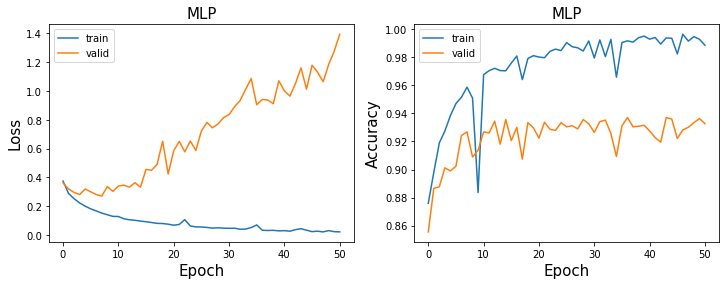

In [7]:
plot_loss_acc(training_losses, val_losses, training_acc, validation_acc, model_type) # embed_dim=64

In [9]:
model = MLP(input_dim=100*10, embed_dim=embed_dim).to(device)
path = '/mnt/pesaranlab/People/Capstone_students/Yue/model/model_Goose_1st_1_upsample'
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_EMBED{}_EPOCH{}.pt'.format(
    path, model_type, CH, loss_type, reg_type, alpha, embed_dim, best_epoch)))

<All keys matched successfully>

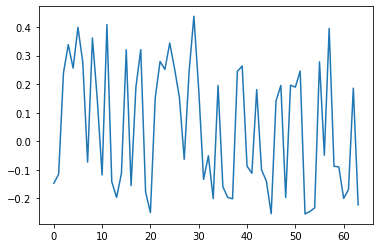

In [10]:
plt.plot(model.linear2.weight.cpu().detach().numpy().flatten())
plt.show()

In [11]:
test_loss, test_acc, test_preds, test_preds_probs, test_labels, cases_wrong_0 = evaluate(model, optimizer, test_loader, alpha=alpha, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('test loss:{} accuracy:{}'.format(test_loss, test_acc))

test loss:0.5320249795913696 accuracy:0.8441538461538461


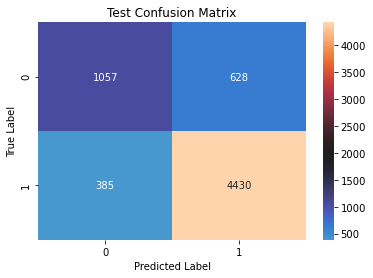

In [12]:
predictions_test = np.concatenate(test_preds)
labels_test = np.concatenate(test_labels)

df_test = pd.DataFrame({'predictions': predictions_test, 'labels': labels_test})

cm_test = confusion_matrix(labels_test, predictions_test)
ax = plt.axes()
sn.heatmap(cm_test, annot = True, fmt = "d", ax = ax, center=2000)
ax.set_title('Test Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()

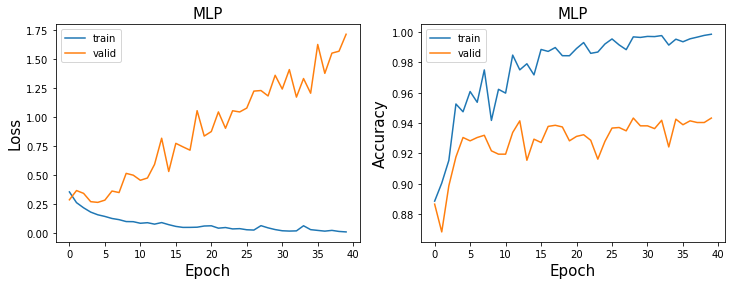

In [7]:
plot_loss_acc(training_losses, val_losses, training_acc, validation_acc, model_type) # embed_dim=256

In [11]:
model = MLP(input_dim=100*10).to(device)
path = '/mnt/pesaranlab/People/Capstone_students/Yue/model/model_Goose_1st_1_upsample'
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_EPOCH{}.pt'.format(
    path, model_type, CH, loss_type, reg_type, alpha, 4)))

<All keys matched successfully>

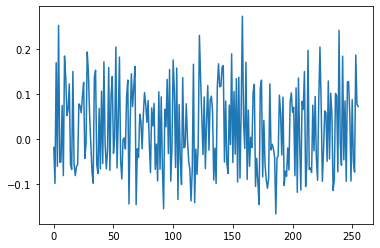

In [13]:
plt.plot(model.linear2.weight.cpu().detach().numpy().flatten())
plt.show()

In [14]:
test_loss, test_acc, test_preds, test_preds_probs, test_labels, cases_wrong_0 = evaluate(model, optimizer, test_loader, alpha=alpha, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('test loss:{} accuracy:{}'.format(test_loss, test_acc))

test loss:0.5888658761978149 accuracy:0.8316923076923077


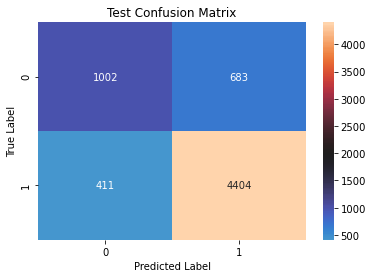

In [15]:
predictions_test = np.concatenate(test_preds)
labels_test = np.concatenate(test_labels)

df_test = pd.DataFrame({'predictions': predictions_test, 'labels': labels_test})

cm_test = confusion_matrix(labels_test, predictions_test)
ax = plt.axes()
sn.heatmap(cm_test, annot = True, fmt = "d", ax = ax, center=2000)
ax.set_title('Test Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()